In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from msapy import plottings as pl
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
import utils as ut
import pandas as pd
import netneurotools.datasets
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid


In [3]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

In [4]:
consensus_mat = scipy.io.loadmat('/home/kayson/Downloads/Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
consensus_mat['LauConsensus']['Readme']

array(['1 - weighted adj mat', '2 - fiber length mat', '3 - fc mat',
       '4 - coordinates', '5{1} - roi name', '5{2} - short name',
       '5{3} - rsn name', '5{4} - hemisphere'], dtype=object)

In [5]:
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][2][0])
labels = consensus_mat['LauConsensus']['Matrices'][2][4][:,0]
human_fc = consensus_mat['LauConsensus']['Matrices'][2][2]
np.fill_diagonal(human_fc,0)

In [28]:
warnings.filterwarnings("ignore")
n_nodes = connectivity.shape[0]
rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02

G =0.74 #this is the optimal value based on the search below
duration = 1000
noise_strength = 0.05

noise = np.zeros((n_nodes,int(duration/delta)+1))
for i in range(int(duration/delta)+1):
    noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))

In [29]:
simple_human_dynamics = ut.differntial_model(adjacency_matrix=connectivity,coupling=G,dt=delta,timescale=tau,input_matrix=noise,duration=duration)

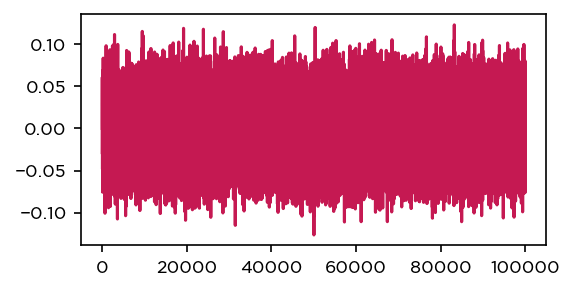

In [30]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_human_dynamics[10],alpha=0.9,color=RED);
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0)
fc = np.nan_to_num(fc)

0.23414722959685388

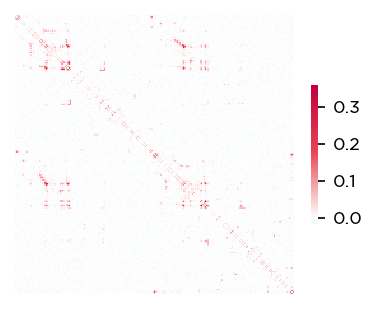

In [31]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);
np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]

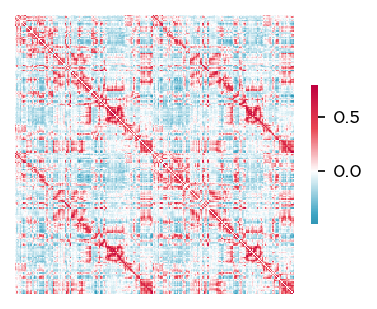

In [10]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(human_fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [11]:
parameter_space = list(ParameterGrid({'G':np.linspace(0.01,1.,20).round(2,)}))

In [13]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.differntial_model(adjacency_matrix=connectivity,
                                    coupling=parameters['G'],
                                    dt=delta,
                                    timescale=tau,
                                    input_matrix=noise,
                                    duration=duration)
    
    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 20/20 [10:06<00:00, 30.30s/it]


In [14]:
optimum_params = max(parameter_space, key=lambda x: x['correlation'])
dynamics = ut.differntial_model(adjacency_matrix=connectivity,
                                    coupling=optimum_params['G'],
                                    dt=delta,
                                    timescale=tau,
                                    input_matrix=noise,
                                    duration=duration)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc,0)
optimum_params

{'G': 0.74, 'correlation': 0.23414722959685388}

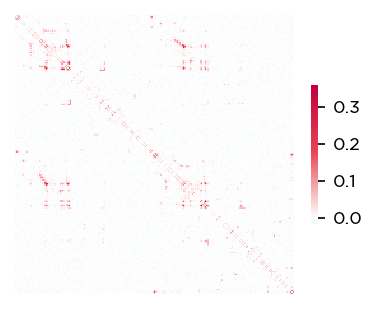

In [15]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);